# Master Notebook

## Notes from meeting

use parallelisation to run them in parallel, if not deploy code on cluster - ask shuxiang. only if decay curve is actually observed!

set dt=1/100 not 1/1000, then compare to dt=1/200 and see if there's a meaningful difference.

get pauli transformation matrix for each gate, which maps the input vector (an equal superposition of all states in the H space) to an output? discuss with shuxiang next time

if takes too long, decrease t1, t2 so less gates required to see decrease in fidelity

ptm tells us what kind of noise is introduced by parameter shift

## Aims

Be able to get the results from the online paper via both pulse-level simulation and PTM?

OR, show what type of error is introduced by analysing the changes in the PTM from parameter drift?

OR, reach the predicted maximum fidelity, measure the noise in the actual systems and compare fidelity of actual to theoretical.

## To-do

- optimise the X90 pulse further
- deconstruct errors into theoretical, leakage, and instrumental. note without noise, theoretical+leakage should be observed. if not, optimisation should be better.
- convert the RBT curve into an error per gate
- which properties of the X90 pulse should be fixed and which should be varied in optimisation?
- look at the paper for leakage benchmarking
- simulate frequency noise separately, range is 1-100kHz
- the old master's project says what the expected noise is in each parameter

## Algorithm

1. Define a transmon class, which acts as a wrapper for various properties. Only the RWA Hamiltonian is currently supported - the rotating frame transformation for the non-RWA Hamiltonian has not been derived. Random noise is added to the optimal parameters upon calling the proper tunction.
2. Optimise an X90 pulse for this transmon, using randomised initial states. 
3. Run a custom circuit to check the functionality
4. Run RBT

## Further notes

Here, we decompose each gate in a circuit into the vZX basis, which has only an X90 gate, and virtual Z gates. This means the only physical gate we have to implement and optimise is the X90 gate, substantially improving computational time.

This decomposition is predicated on the fact that the general gate

$$U(\theta,\phi,\lambda)=\begin{pmatrix}
\cos{\theta/2}&-e^{-\imath\lambda}\sin{\theta/2}\\
e^{\imath\phi}\sin{\theta/2}&e^{\imath(\phi+\lambda)}\cos{\theta/2}
\end{pmatrix}$$

Can be deconstructed into

$$Z(φ-π/2) @ X(π/2) @ Z(π-θ) @ X(π/2) @ Z(λ-π/2)$$

> $@$ means matrix multiplication. It is important to note that numpy operations by default are elementwise!

Where the virtual $Z$ gates are implemented by shifting the phase of **all** the subsequent $X$ pulses.

Furthermore, it is easier to work in the rotating basis. Instead of applying the rotating frame transformation to the operators, which increases computational load to the point where the simulation is unusable, I have opted to simply apply a time-varying rotation to each state in the final result, without loss of generality.

However, the *frequency* of this rotation is currently only known for the transmon Hamiltonian which has been derived using the RWA. To simulate the full non-approximated transmon, the frequency at which the transmon oscillates under that Hamiltonian must be derived. It is then a matter of checking whether the RWA is being used, and using the appropriate frequency.

When doing spectroscopy, a spike in P(f) is seen at Ω02/2, meaning multiple-photon transitions are already included.


### Imports

In [1]:
from transmon import Transmon
from optimise_X90 import create_X90_pulse
from helpers import *
from simulate import *
from RBT import perform_RBT

from qutip import *
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

### Define the transmon

Original transmon

In [2]:
tr = Transmon(n_levels=8, initial_state=0, Ω=5000, α=-100, RWA=True, dt=1/1000)
tr.X90_args = {'A': 7.449877548484732, 'Γ': 0.5024320350942441, 'ω': 5000.0, 'A_DRAG': -0.0034947574297965116}

New transmon

In [5]:
tr = Transmon(n_levels=8, initial_state=0, Ω=5000, α=-100, RWA=False, dt=1/1000, t_decay=50, t_dephase=50, A_noise=1, φ_noise=0.1)
tr.X90_args = {'A': 7.746638104844691, 'Γ': 0.453458323548966, 'ω': 5000.0, 'A_DRAG': -0.1}

### Optimise the X90 pulse

Optimising A
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 


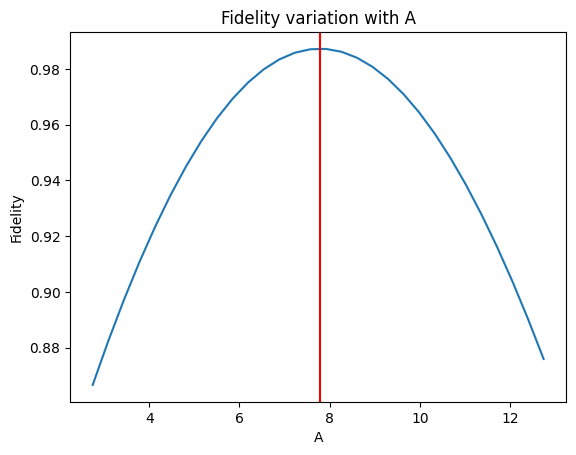

Optimising Γ
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

In [6]:
t = np.arange(0, 1, tr.dt)
semiranges = {"A":5, "Γ":0.4, "A_DRAG":0.1}

tr.X90_args = create_X90_pulse(t, tr, args=tr.X90_args, semiranges=semiranges, plot=True, rand_init=False, N=30)

Test the X90 pulse

In [ ]:
# test from 0 to - (minus)

%matplotlib qt

targ = (basis(tr.n_levels, 0)-1j*basis(tr.n_levels, 1)).unit()

res, f = simulate(tr, tr.X90_args, target=targ, noise=False, plot=True)
print(f)

In [ ]:
# test random initial

tr.ψ0 = expand(rand_ket(2), tr.n_levels)
targ = expand(calculate_target_state([U(gate_angles["X90"])], truncate(tr.ψ0), plot=False), tr.n_levels)

res, f = simulate(tr, tr.X90_args, target=targ, noise=False, plot=True)
print(f)

tr.ψ0 = basis(tr.n_levels, 0)

### Test a circuit

In [ ]:
# %matplotlib qt

# define which two gates are to be tested
gate1 = "X90"
gate2 = "Z90"

This cell tests a circuit of two gates by simulating each pulse individually - it is a proof of concept.

In [ ]:
# define variables to be used later
# note t is just the pulse width because we simulate each pulse individually
target = calculate_target_state([gate1, gate2], tr.ψ0)
target = expand(target, tr.n_levels)
tr.ψ0 = basis(tr.n_levels, 0)

# prep for plotting
b = Bloch()
b.make_sphere()
b.add_states(truncate(tr.ψ0))
b.add_states(truncate(target))

# gate 1
θ, φ, λ = gate_angles[gate1]
total_phase = 0

total_phase += (λ-np.pi/2)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (np.pi-θ)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (φ-np.pi/2)

# gate 2
θ, φ, λ = gate_angles[gate2]
total_phase += (λ-np.pi/2)
args = tr.get_noisy_args()
args["φ"] += total_phase
tr.ψ0 = simulate(tr, args, target=None, plot=False)[-1]

total_phase += (np.pi-θ)
args = tr.get_noisy_args()
args["φ"] += total_phase
results = simulate(tr, args, target=None, plot=False)

total_phase += (φ-np.pi/2)

# final rotation to account for virtual z gates throughout
result = rotate_z(results[-1], total_phase)

print("Fidelity: " + str(fidelity(result, target)))

b.add_states(truncate(result))
b.render()
b.show()

This cell tests a circuit using the implemented function `simulate_circuit`

In [ ]:
tr.ψ0 = basis(tr.n_levels, 0)
gate1 = "X90"
gate2 = "Z90"
gate3 = "Z180"
gate4 = "Y90"

c = [U(gate_angles[gate1]), U(gate_angles[gate2]), U(gate_angles[gate3]), U(gate_angles[gate4])]

res, f = simulate_circuit(tr, c, noise=True, plot=True)

### Perform RBT

In [ ]:
tr.ψ0 = basis(tr.n_levels, 0)
fidelities = perform_RBT(tr, max_length=20, iterations=10, plot=True)